In [1]:
import os
from PIL import Image
import pandas as pd 
import glob
import random as r
from tqdm import tqdm

In [2]:
data_path = "/home/ubuntu/noaa-hackathon/data"

In [5]:
data.value.value_counts()

animal                15040
no_animal                71
no_visible_animals       17
Name: value, dtype: int64

In [9]:
data[data.value == "animal"].filename.iloc[0]

'rockfish_full/SHE-11/Labeled_8_s_1_100/20111010.210720.00181_uncropped_rect_color.jpg'

In [25]:
len(data.filename.unique())

7644

In [10]:
# final, coco-formatted data, to be written to json
train_coco = {}
val_coco = {}

train_info = {
    "url": "http://fishnet.ai",
    "version": "0.2.0",
    "year": 2020,
    "contributor": "The Nature Conservancy",
}
train_coco['info'] = train_info

val_info = {
    "url": "http://fishnet.ai",
    "version": "0.2.0",
    "year": 2020,
    "contributor": "The Nature Conservancy",
}
val_coco['info'] = val_info

licenses = []
train_coco['licenses'] = licenses
val_coco['licenses'] = licenses

categories = [ { "supercategory": "THING", "id": 1 , "name": "THING" }]
train_coco['categories'] = categories
val_coco['categories'] = categories

In [11]:
from PIL import Image

def height(img):
    image = Image.open(img)
    return image.size[1]

def width(img):
    image = Image.open(img)
    return image.size[0]

In [13]:
train_subset = data[data.is_validation == False].filename.unique()
train_images = []
for i, img in tqdm(enumerate(train_subset)):
    img_path = os.path.join(data_path, img)
    if os.path.exists(img_path):
        train_images.append({ 
            "file_name": img,
             "height": height(img_path),
             "width": width(img_path),
             "id": img,
           })
print(train_images[0])
train_coco['images'] = train_images

6465it [00:03, 1722.97it/s]

{'file_name': 'rockfish/OCNMS_port/20170826.171537.01081.tif', 'height': 2050, 'width': 2448, 'id': 'rockfish/OCNMS_port/20170826.171537.01081.tif'}


In [16]:
val_subset = data[(data.is_validation == True)].filename.unique()
val_images = []
for i, img in tqdm(enumerate(val_subset)):
    img_path = os.path.join(data_path, img)
    if os.path.exists(img_path):
        val_images.append({ 
            "file_name": img,
             "height": height(img_path),
             "width": width(img_path),
             "id": img
            })
print(val_images[0])
val_coco['images'] = val_images

1528it [00:00, 1735.15it/s]

{'file_name': 'rockfish/OCNMS_port/20170902.211530.01852.tif', 'height': 2050, 'width': 2448, 'id': 'rockfish/OCNMS_port/20170902.211530.01852.tif'}


In [17]:
len(val_coco["images"])

1527

In [18]:
# coco bounding box format is [top left x position, top left y position, width, height]
# TODO clip
def get_coco_bbox(xmin, xmax, ymin, ymax):
    return [ xmin, ymin, (xmax - xmin), (ymax - ymin) ]

# TODO clip, prevent negative
# divide by 2 like in camera traps example
def get_coco_area(xmin, xmax, ymin, ymax):
    return (xmax-xmin)*(ymax-ymin) / 2

In [26]:
display(data.value.value_counts())
no_animal0 = (data.value != "no_animal")
no_animal1 = (data.value != "no_visible_animals")
no_animals = no_animal0 & no_animal1

data[no_animals].value.value_counts()

animal                15040
no_animal                71
no_visible_animals       17
Name: value, dtype: int64

animal    15040
Name: value, dtype: int64

In [27]:
data_no_animals = data[no_animals]

In [28]:
train_annotations = []
val_annotations = []
x_min = 'x_min'
y_min = 'y_min'
x_max = 'x_max'
y_max = 'y_max'
img_id = 'filename'

for index, row in tqdm(data_no_animals.iterrows()):
    annotation = {
        "bbox": get_coco_bbox(row[x_min], row[x_max], row[y_min], row[y_max]),
        "area": get_coco_area(row[x_min], row[x_max], row[y_min], row[y_max]),
        "iscrowd": 0, # TODO: some of these ARE crowds!
        "image_id": row[img_id],
        "category_id": 1, # always a FISH
        "id": int(index) # annotation ID must be an int
    }
    if (row.is_validation == False):
        train_annotations.append(annotation)
    elif (row.is_validation == True):
        val_annotations.append(annotation)

train_coco['annotations'] = train_annotations
val_coco['annotations'] = val_annotations

35110it [00:05, 6982.29it/s]


In [30]:
print(len(train_coco['images'])) 
print(len(val_coco['images']))

6463
1527


In [128]:
bboxes_df.to_csv("training_sample.csv", index=False)

In [31]:
import json

with open('jimmy_fct_lynker_train.json', 'w') as fp:
    json.dump(train_coco, fp)
    
with open('jimmy_fct_lynker_val.json', 'w') as fp:
    json.dump(val_coco, fp)

In [29]:
im = Image.open('OCNMS_port/20170822.184007.01705.tif')

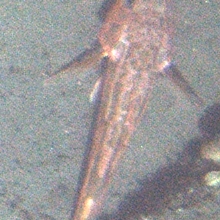

In [33]:
cr = im.crop((1995,1187,2215,1407)) 